In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

plt.style.use('default')
sns.set_theme(context='notebook')

df = pd.read_csv('cleaned_data/nba_playoff_2015_2024_structured.csv')
os.makedirs('visualizations', exist_ok=True)
warnings.simplefilter(action='ignore')

In [2]:
# Converts "mm:ss" to seconds
def time_to_seconds(t):
    try:
        minutes, seconds = map(float, str(t).split(":"))
        return minutes*60 + seconds
    except:
        return np.nan

# Extracting score margin (home - away)
def score_margin(score):
    try:
        away, home = map(int, str(score).split('-'))
        return home - away
    except:
        return np.nan

# Extracting year from source_url
df['year'] = df['source_url'].str.extract(r'(\d{4})')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

df['seconds_left'] = df['time_left'].apply(time_to_seconds)
df['score_margin'] = df['score'].apply(score_margin)

In [3]:
# cleaning shooter names
df['shooter'] = df['shooter'].str.replace(r'(makes|misses)$', '', regex=True).str.strip()

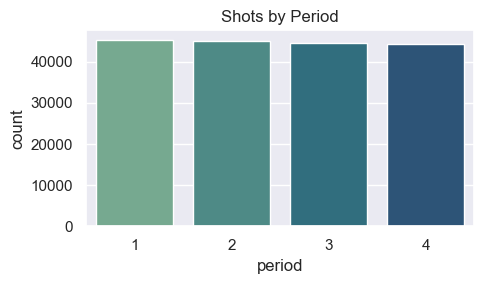

In [4]:
# Shots by Period bar plot
plt.figure(figsize=(5,3))
sns.countplot(x='period', data=df, palette='crest')
plt.title('Shots by Period')
plt.tight_layout()
plt.savefig('visualizations/shots_by_period.png', dpi=120, bbox_inches='tight')
plt.show()

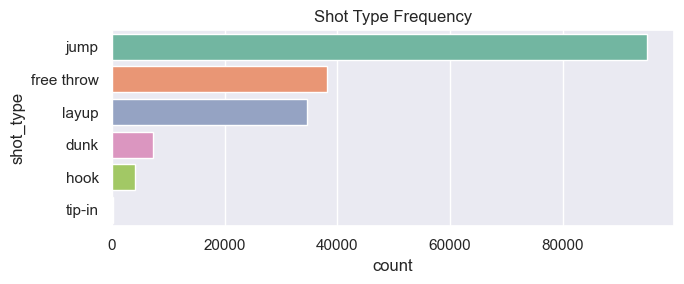

In [5]:
# Shot Type Frequency bar plot
plt.figure(figsize=(7,3))
sns.countplot(y='shot_type', data=df, order=df['shot_type'].value_counts().index, palette='Set2')
plt.title('Shot Type Frequency')
plt.tight_layout()
plt.savefig('visualizations/shot_type_frequency.png', dpi=120, bbox_inches='tight')
plt.show()

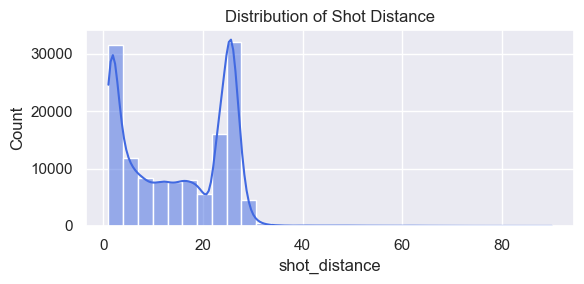

In [6]:
# Shot Distance Distribution histogram
plt.figure(figsize=(6,3))
sns.histplot(df['shot_distance'].dropna(), bins=30, kde=True, color='royalblue')
plt.title('Distribution of Shot Distance')
plt.tight_layout()
plt.savefig('visualizations/shot_distance_distribution.png', dpi=120, bbox_inches='tight')
plt.show()

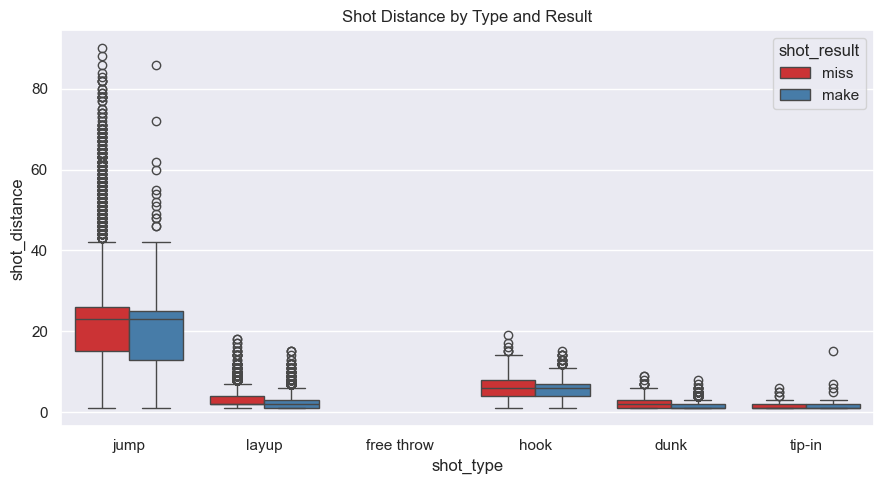

In [7]:
# Shot Distance by Type and Result box plot
plt.figure(figsize=(9,5))
sns.boxplot(x='shot_type', y='shot_distance', hue='shot_result', data=df, palette='Set1')
plt.title('Shot Distance by Type and Result')
plt.tight_layout()
plt.savefig('visualizations/shot_distance_by_type_box.png', dpi=120, bbox_inches='tight')
plt.show()

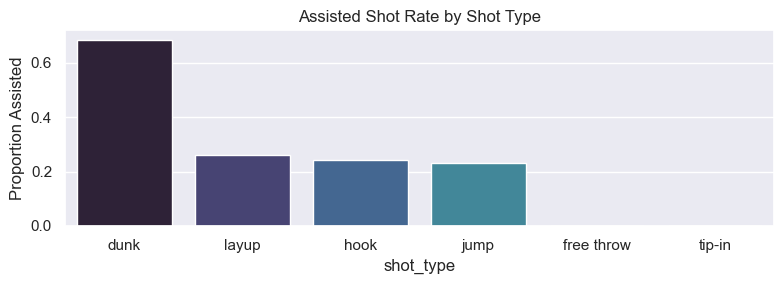

In [8]:
# bar plot for assisted shot rate by shot type
assist_rate = df.groupby('shot_type')['assisted_by'].apply(lambda x: (x != 'Unassisted').mean()).sort_values(ascending=False)
plt.figure(figsize=(8,3))
sns.barplot(x=assist_rate.index, y=assist_rate.values, palette='mako')
plt.ylabel('Proportion Assisted')
plt.title('Assisted Shot Rate by Shot Type')
plt.tight_layout()
plt.savefig('visualizations/assisted_shot_rate_by_type.png', dpi=120, bbox_inches='tight')
plt.show()

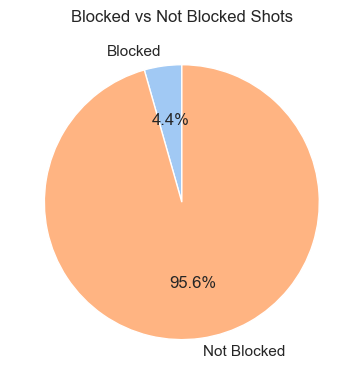

In [9]:
# Blocked shots pie chart
is_blocked = (df['blocked_by'].notna()) & (df['blocked_by'] != 'Not Blocked')
labels = ['Blocked', 'Not Blocked']
sizes = [is_blocked.sum(), (~is_blocked).sum()]
colors = sns.color_palette('pastel')[0:2]
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Blocked vs Not Blocked Shots')
plt.tight_layout()
plt.savefig('visualizations/blocked_pie.png', dpi=120, bbox_inches='tight')
plt.show()

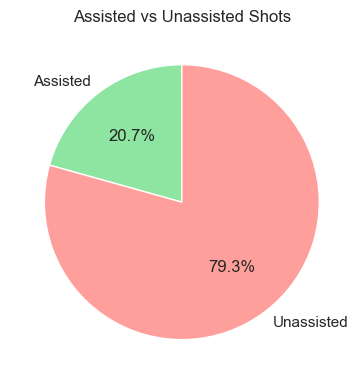

In [10]:
# Assisted vs Unassisted Shots pie chart
is_assisted = (df['assisted_by'].notna()) & (df['assisted_by'] != 'Unassisted')
labels = ['Assisted', 'Unassisted']
sizes = [is_assisted.sum(), (~is_assisted).sum()]
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('pastel')[2:4], startangle=90)
plt.title('Assisted vs Unassisted Shots')
plt.tight_layout()
plt.savefig('visualizations/assisted_pie.png', dpi=120, bbox_inches='tight')
plt.show()

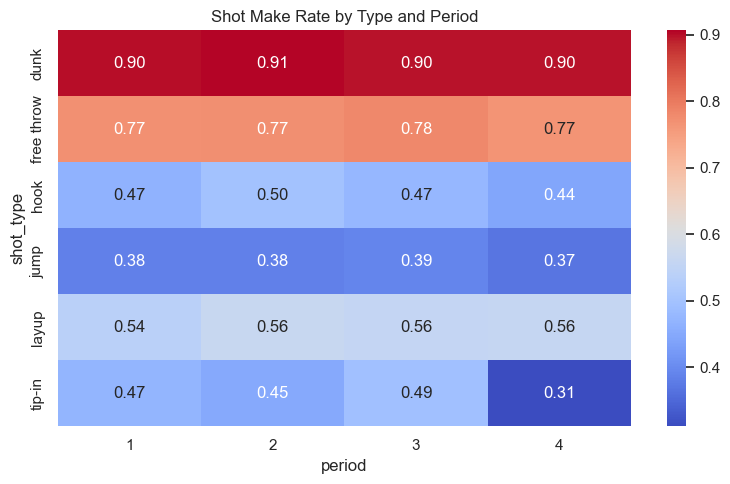

In [11]:
# Shot Make Rate by Type and Period heatmap
pivot = pd.pivot_table(df, index='shot_type', columns='period',
                       values='shot_result', aggfunc=lambda x: (x=='make').mean())
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Shot Make Rate by Type and Period')
plt.tight_layout()
plt.savefig('visualizations/shot_make_rate_by_type_period_heatmap.png', dpi=120, bbox_inches='tight')
plt.show()

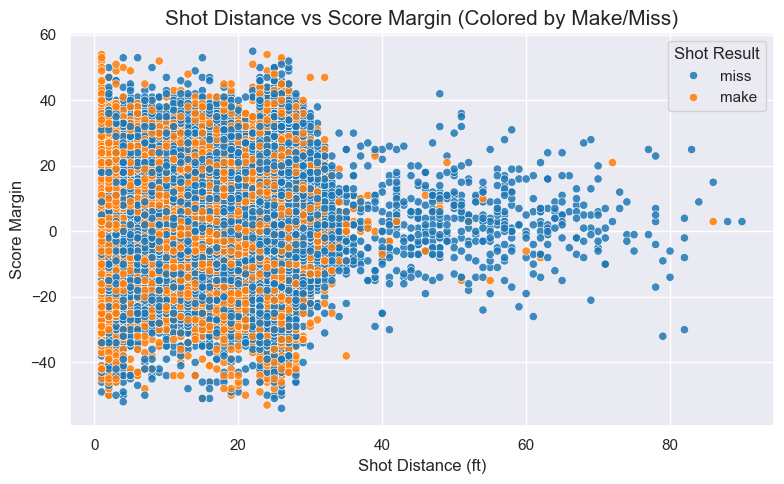

In [12]:
# Scatter plot for shot distance vs score margin
data_plot = df[['shot_distance', 'score_margin', 'shot_result']].dropna()
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='shot_distance',
    y='score_margin',
    hue='shot_result',
    palette='tab10',
    alpha=0.85,
    data=data_plot,    
    linewidth=0.5
)
plt.title('Shot Distance vs Score Margin (Colored by Make/Miss)', fontsize=15)
plt.xlabel('Shot Distance (ft)', fontsize=12)
plt.ylabel('Score Margin', fontsize=12)
plt.legend(title='Shot Result', loc='upper right')
plt.tight_layout()
plt.savefig('visualizations/shot_distance_vs_score_margin_scatter.png', dpi=120, bbox_inches='tight')
plt.show()

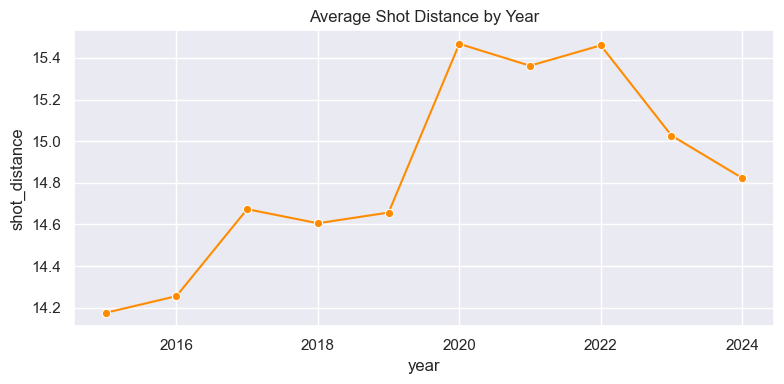

In [13]:
# Average Shot Distance by Year line plot
avg_dist = df.groupby('year')['shot_distance'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(data=avg_dist, x='year', y='shot_distance', marker='o', color='darkorange')
plt.title('Average Shot Distance by Year')
plt.tight_layout()
plt.savefig('visualizations/avg_shot_distance_by_year.png', dpi=120, bbox_inches='tight')
plt.show()

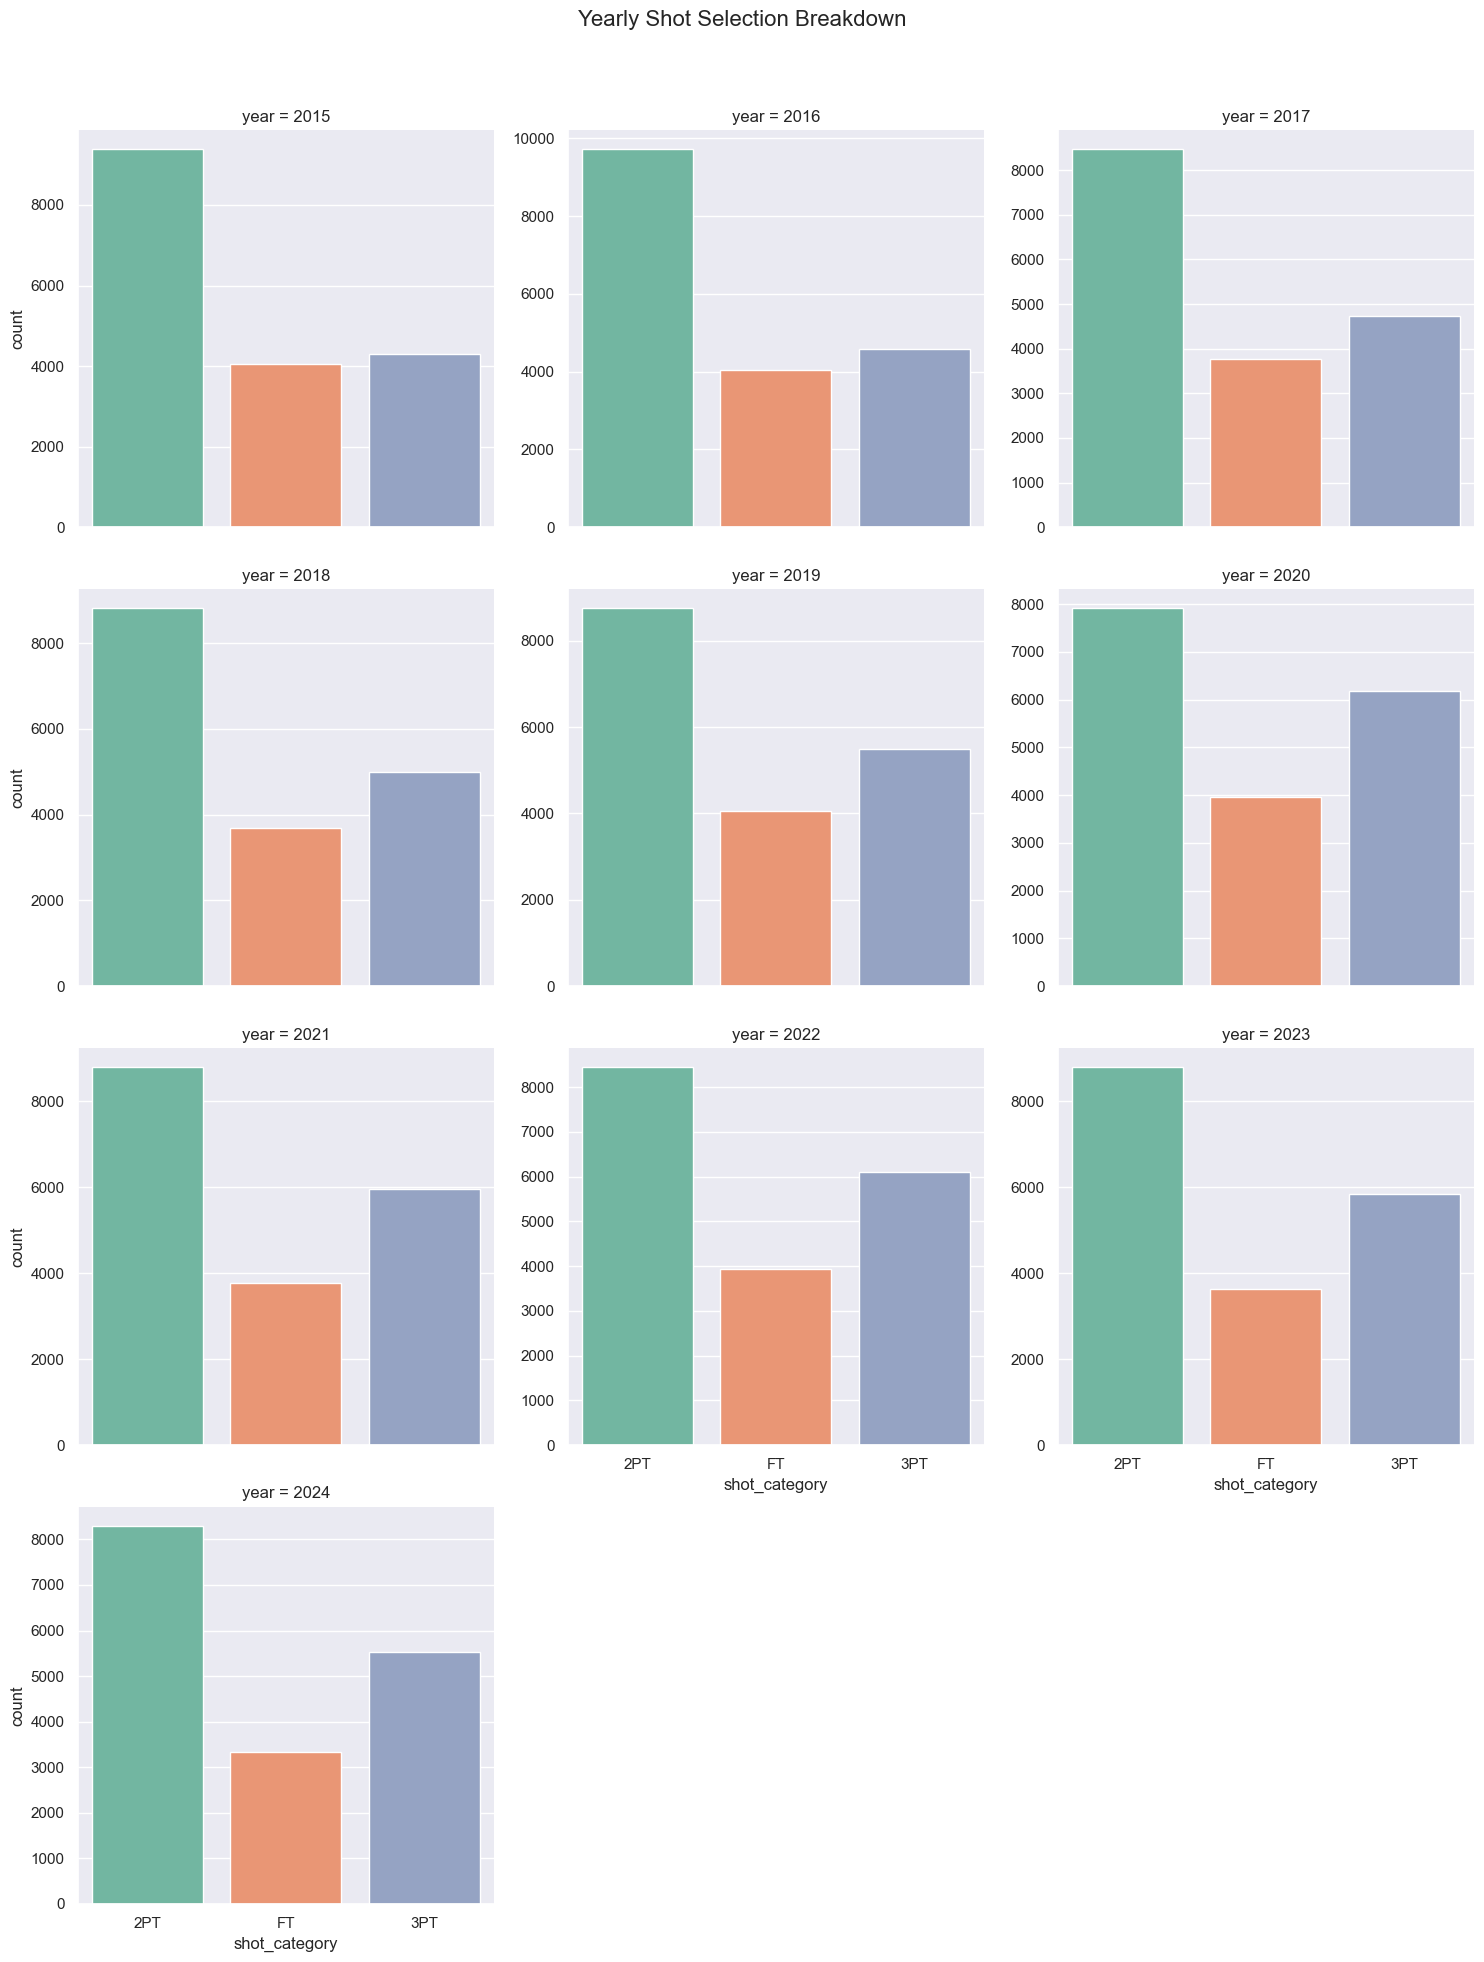

In [14]:
# yearly shot distribution visualization
# Year
df['year'] = df['source_url'].str.extract(r'(\d{4})').astype(int)

is_ft = df['shot_type'].str.contains('free throw', case=False, na=False)
is_3_text = df['shot_type'].str.contains(r'\b(3|three)[ -]?(pt|pointer)\b', case=False, na=False)
is_3_dist = df['shot_distance'].ge(22)

df['shot_category'] = np.select(
    [is_ft, is_3_dist | is_3_text],
    ['FT', '3PT'],
    default='2PT'
)

# FacetGrid (will now show 3PT)
g = sns.catplot(
    data=df,
    x='shot_category',
    kind='count',
    col='year',
    col_wrap=3,
    palette='Set2',
    sharey=False
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Yearly Shot Selection Breakdown', fontsize=16)
plt.savefig('visualizations/yearly_shot_selection_facetgrid.png', dpi=120, bbox_inches='tight')
plt.show()

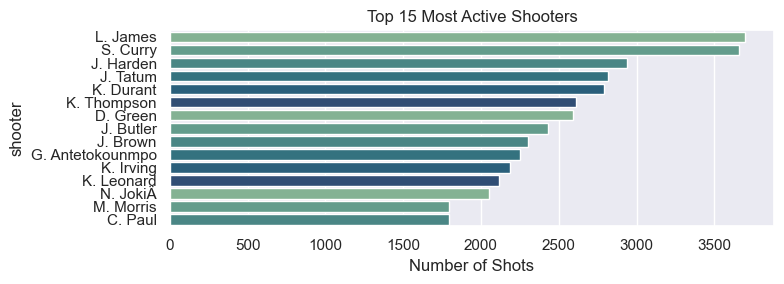

In [15]:
# Bar plot for top 15 shooters
top_shooters = df['shooter'].value_counts().head(15)
plt.figure(figsize=(8,3))
sns.barplot(x=top_shooters.values, y=top_shooters.index, orient='h', palette=sns.color_palette("crest", as_cmap=False))
plt.title('Top 15 Most Active Shooters')
plt.xlabel('Number of Shots')
plt.tight_layout()
plt.savefig('visualizations/shooter_top15.png', dpi=120, bbox_inches='tight')
plt.show()

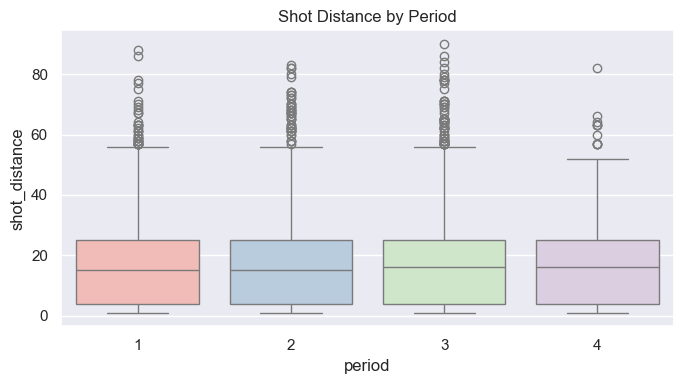

In [16]:
# Shot Distance by Period box plot
plt.figure(figsize=(7,4))
sns.boxplot(x='period', y='shot_distance', data=df, palette='Pastel1')
plt.title('Shot Distance by Period')
plt.tight_layout()
plt.savefig('visualizations/shot_distance_by_period_boxplot.png', dpi=120, bbox_inches='tight')
plt.show()

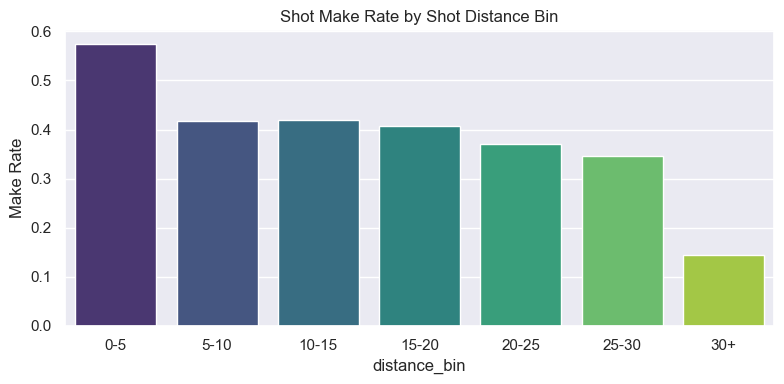

In [17]:
# Shot Make Rate by Distance Bin bar plot
df['distance_bin'] = pd.cut(df['shot_distance'], bins=[0,5,10,15,20,25,30,100], labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'])
make_rate_by_dist = df.groupby('distance_bin')['shot_result'].apply(lambda x: (x=='make').mean())
plt.figure(figsize=(8,4))
sns.barplot(x=make_rate_by_dist.index, y=make_rate_by_dist.values, palette='viridis')
plt.title('Shot Make Rate by Shot Distance Bin')
plt.ylabel('Make Rate')
plt.tight_layout()
plt.savefig('visualizations/make_rate_by_distance_bin.png', dpi=120, bbox_inches='tight')
plt.show()

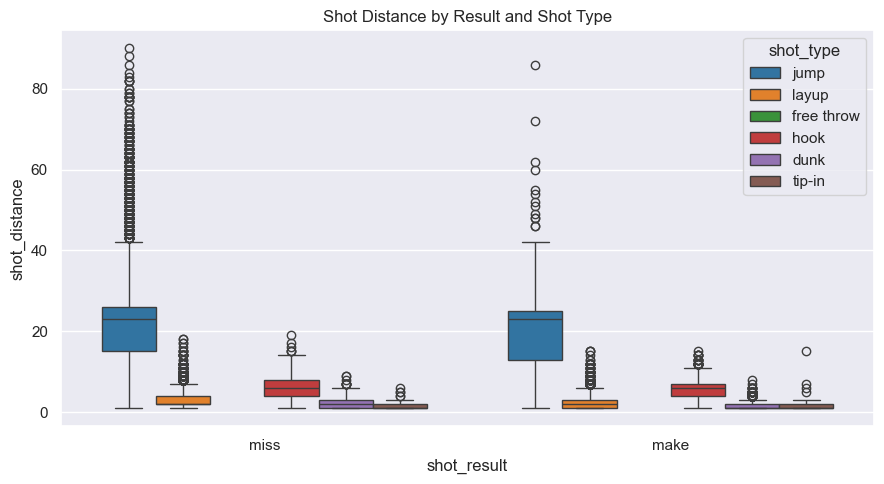

In [18]:
# Shot Distance by Result and Shot Type box plot
plt.figure(figsize=(9,5))
sns.boxplot(
    x='shot_result',
    y='shot_distance',
    hue='shot_type',
    data=df,
    palette='tab10'
)
plt.title('Shot Distance by Result and Shot Type')
plt.tight_layout()
plt.savefig('visualizations/shot_distance_by_result_boxplot.png', dpi=120, bbox_inches='tight')
plt.show()

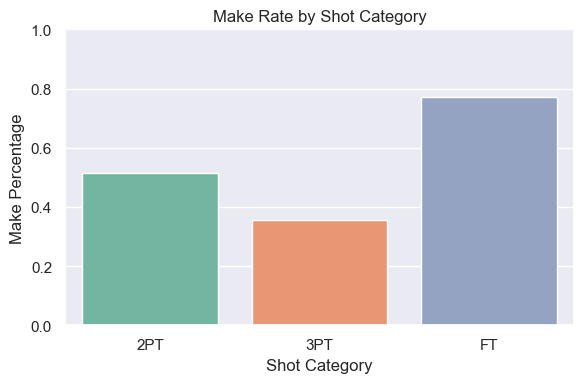

In [19]:
# bar plot showing make rates by shot category
df['shot_category'] = np.where(df['shot_distance'] >= 22, '3PT', '2PT')
df.loc[df['shot_type'] == 'free throw', 'shot_category'] = 'FT'

make_rates = df.groupby('shot_category')['shot_result'].apply(lambda x: (x=='make').mean()).reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='shot_category', y='shot_result', data=make_rates, palette='Set2')
plt.title('Make Rate by Shot Category')
plt.ylabel('Make Percentage')
plt.xlabel('Shot Category')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('visualizations/make_rate_by_shot_category.png', dpi=120, bbox_inches='tight')
plt.show()

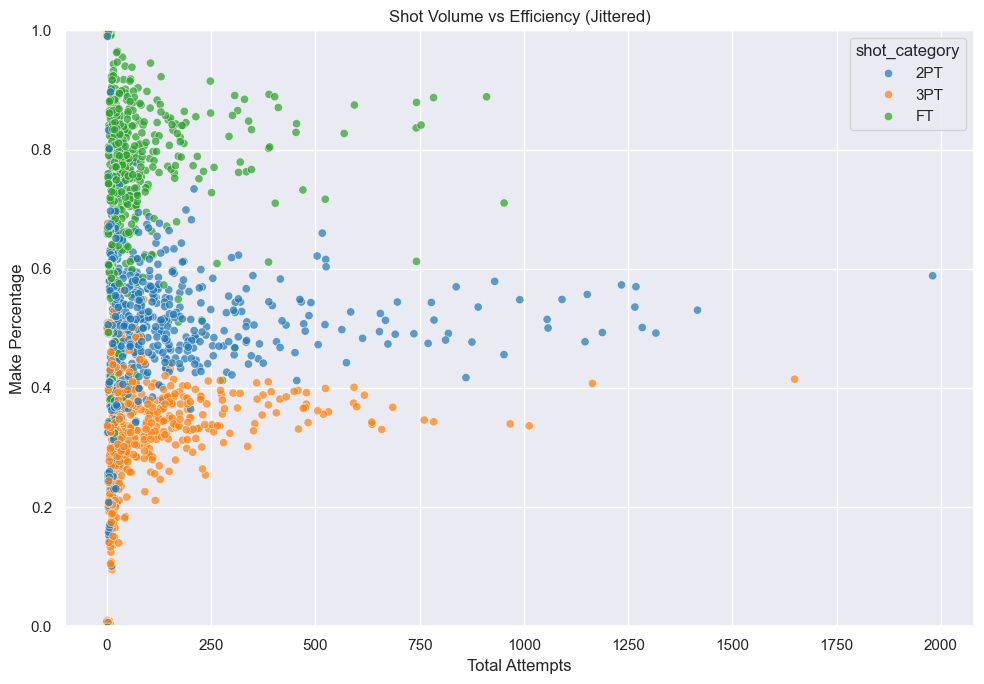

In [20]:
# scatter plot showing shot attempts vs make percentage
shot_stats = (
    df.groupby(['shooter', 'shot_category'])
      .agg(
          attempts=('shot_result', 'count'),
          make_pct=('shot_result', lambda x: (x == 'make').mean())
      )
      .reset_index()
)

jitter_df = shot_stats.copy()
jitter_df['attempts'] += np.random.uniform(-2, 2, len(jitter_df))
jitter_df['make_pct'] += np.random.uniform(-0.01, 0.01, len(jitter_df))

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=jitter_df, x='attempts', y='make_pct',
    hue='shot_category', palette='tab10', alpha=0.7
)
plt.ylim(0, 1)
plt.title('Shot Volume vs Efficiency (Jittered)')
plt.xlabel('Total Attempts')
plt.ylabel('Make Percentage')
plt.tight_layout()
plt.show()

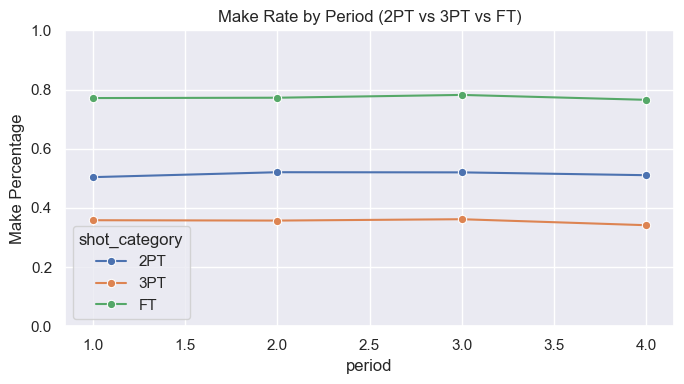

In [21]:
# line plot showing make rates by period
make_rate_period = df.groupby(['period','shot_category'])['shot_result'].apply(lambda x: (x=='make').mean()).reset_index()

plt.figure(figsize=(7,4))
sns.lineplot(x='period', y='shot_result', hue='shot_category', data=make_rate_period, marker='o')
plt.title('Make Rate by Period (2PT vs 3PT vs FT)')
plt.ylabel('Make Percentage')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('visualizations/make_rate_by_period_category.png', dpi=120, bbox_inches='tight')
plt.show()